<a href="https://colab.research.google.com/github/josephasal/cosmo_inference/blob/main/neural_network/simulating_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Used to generate training data, using same exact functions defined before

In [1]:
import numpy as np
#Dimensionless distance modulus function implementation

#Distance modulus function
def calculate_distance_modulus(z, omega_m,h):
  """
  Calculates dimensionless theoretical distance modulus using

  inputs:
   - z: Redshift
   - omega_m: density matter parameter
   - h: dimensionless hubble constance H0 = 100h km/s/Mpc

   outputs: theoretical distance modulus
  """
  c = 299792.458   # speed of light in km/s
  H0 = 100 * h     # Hubble constant in km/s/Mpc

  #Luminosity distance based on Penn 1999 analytic solution

  #Fitting function
  def eta(a,omega_m):
    """
    Fits eta
    inputs:
      a - a number
      omega_m - matter density

    outputs: eta as a function of a and omega_m
    """
    s = ((1-omega_m)/omega_m)**(1/3)
    eta = 2*np.sqrt(s**3 +1) * ((1/(a**4)) - 0.1540*(s/(a**3)) + 0.4304 *((s**2)/(a**2)) + 0.19097*((s**3)/a) + 0.066941*(s**4))**(-1/8)

    return eta

  #Calculate eta for 1 and 1/z+1
  a = 1/(z+1)
  eta_1 = eta(1,omega_m)
  eta_z = np.array([eta(ai, omega_m) for ai in a])

  #Dimensionless luminosity distance calculation
  d_L_star = (c/H0) * (1+z) * (eta_1 - eta_z)



  #Now to calculate distance modulus mu
  theoretical_mu = 25 + 5*np.log10(d_L_star)
  return theoretical_mu

* Input X is distance modulus for various z values
* Output Y is pair of parameters [omega_m,h]

In [2]:
#training data generation

#how many samples i want
training_samples = 10000

#setting ranges for omega m and h based on values that are plausible (from planck 2018)
omega_m_samples = np.random.uniform(0.25,0.35, training_samples)
h_samples = np.random.uniform(0.65,0.8, training_samples)

#grid of redshift values
redshifts = np.linspace(0.001,1,100)
zero_point_offset = 0.05

#calulcating distance moudulus for each parameter across the 100 redshift values
mu = []
for omega_m_i, hi in zip(omega_m_samples, h_samples):
  mu_vector = calculate_distance_modulus(redshifts, omega_m_i, hi)
  mu_vector_offset = mu_vector + zero_point_offset
  mu_noisy_vector = mu_vector_offset + np.random.normal(0, 0.181, mu_vector.shape) #adding noise to the data, based on mean error in the observation data
  mu.append(mu_noisy_vector)

#Definfing training examples:

#converting list into numpy array
X_train = np.array(mu)

#use numpy column stack to take the two arrays and put them side by side, first column is omega m second column is h
Y_train = np.column_stack((omega_m_samples, h_samples))

In [3]:
#checking shape of x and y
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (10000, 100)
Y_train shape: (10000, 2)


* X train is 5000 training examples of mu computed at 100 different redshifts
* Y train is 5000 training examples of omega m and h at the respective mu(z)

Exporting this is a csv

In [4]:
import pandas as pd

x_columns = [f'mu_z{i+1}' for i in range(X_train.shape[1])]
df_X = pd.DataFrame(X_train, columns = x_columns)

df_Y = pd.DataFrame(Y_train, columns = ['omega_m', 'h'])

#combining
training_examples = pd.concat([df_X,df_Y], axis = 1)

#export as csv
training_examples.to_csv('noisy_training_dataNEW3.csv', index = False)

In [5]:
#comparing to observed data
#loading in the supernova data set
import numpy as np
import pandas as pd

filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Restructured code/LOWZ+ESSENCE+SNLS.csv'
supernova_df = pd.read_csv(filepath)

#defining variables
redshift = supernova_df['Z'].values
distance_mod = supernova_df['MU'].values
err_distance_mod = supernova_df['MUERR']  #can maybe incorporate this into a bayesian neural network??
supernova_df.shape

(151, 15)

In [17]:
!pip install SciencePlots

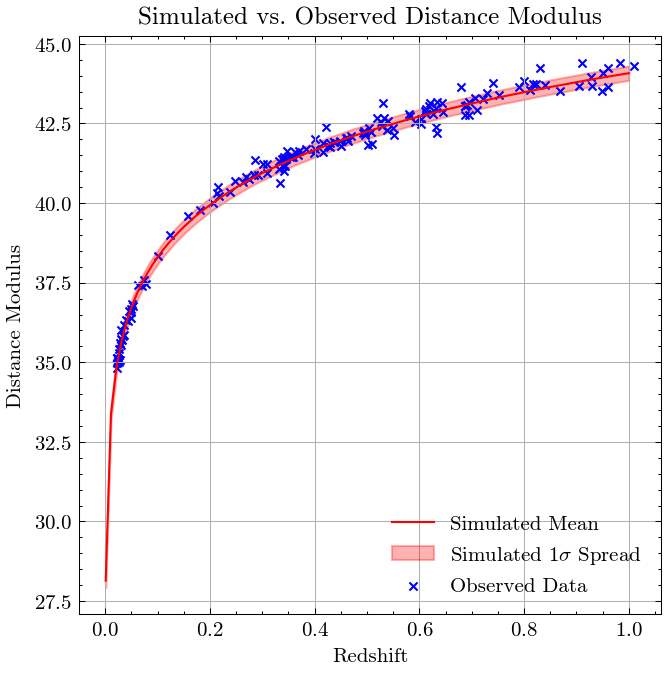

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

#simulated mean and std

sim_mean = np.mean(X_train, axis=0)
sim_std  = np.std(X_train, axis=0)


plt.style.use(['science', 'no-latex'])
plt.figure(figsize=(5, 5), dpi = 150)

# Plot the simulated training data envelope
plt.plot(redshifts, sim_mean, color='red', label='Simulated Mean')
plt.fill_between(redshifts, sim_mean - sim_std, sim_mean + sim_std, color='red', alpha=0.3, label='Simulated 1$\sigma$ Spread')

# Plot the observed data with error bars
plt.scatter(redshift, distance_mod, marker='x', color='blue',
             s=15, label='Observed Data')

# Labeling the plot
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Simulated vs. Observed Distance Modulus')
plt.legend()
plt.grid(True)
plt.show()
